In [23]:
from snn_delays.datasets.custom_datasets import CustomDataset
from snn_delays.config import DATASET_PATH
from torch.utils.data import DataLoader
import os

from snn_delays.utils.memory_cached_dataset import MemoryCachedDataset
import numpy as np

from snn_delays.snn_refactored import SNN
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_minimal
# from snn_delays.utils.visualization_utils import plot_taus
import numpy as np
device = get_device()

'''
3-letter classification dataset (permuted without repetition)

in total, 6 classes

'''

#data = np.load(os.path.join(DATASET_PATH, 'raw_datasets', 'Letters', 'letter_classification_dataset.npz'))
data = np.load(os.path.join(DATASET_PATH, 'Letters', 'three_permuted_letter_classification_dataset.npz'))

train_data = data['train_data']
test_data = data['test_data']
train_labels= data['train_labels']
test_labels = data['test_labels']

num_samples = len(train_labels)

train_dataset = CustomDataset(train_data, train_labels)
test_dataset = CustomDataset(test_data, test_labels)

dataset_dict = train_dataset.get_train_attributes()

cached_train_dataset = MemoryCachedDataset(train_dataset, device=device)
cached_test_dataset = MemoryCachedDataset(test_dataset, device=device)

total_time = train_data.shape[1]
print(f'num timesteps per sample: {total_time}')
batch_size = 128

train_loader = DataLoader(cached_train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=False,
                            num_workers=0)

test_loader = DataLoader(cached_test_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=False,
                            num_workers=0)

dataset_dict["time_ms"] = 1e3
dataset_dict["dataset_name"] = "letters"

Running on: cuda:0


Initializing GPU cache for 2400 samples...
Cache initialized in 0.04 seconds
Initializing GPU cache for 600 samples...
Cache initialized in 0.01 seconds
num timesteps per sample: 48


In [4]:
num_h = 64

time_window = 48

tau_m = 'log-uniform-st'

extra_kwargs = {'multifeedforward':3}
snn_f = SNN(dataset_dict, structure=(num_h, 2, 'mf'), win=time_window, tau_m=tau_m,
             loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_f.set_layers()
snn_f.to(device)

snn_rnn = SNN(dataset_dict, structure=(num_h, 2, 'r'), win=time_window, tau_m=tau_m,
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False)

snn_rnn.set_layers()
snn_rnn.to(device)

extra_kwargs = {'delay_range':(18, 1),
                'pruned_delays': 3}

snn_rd = SNN(dataset_dict, structure=(num_h, 2, 'd'), win=time_window, tau_m=tau_m,
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_rd.set_layers()
snn_rd.to(device)

Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms


SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=25, out_features=64, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=1152, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=6, bias=False)
    )
  )
)

In [ ]:
ckpt_dir = 'permuted_3letters_task'
num_epochs = 50

lr_tau = 0.1

train(snn_f, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)
train(snn_rnn, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)
train(snn_rd, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)

Epoch [1/50], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [6/18], Loss: 10.10165
Step [12/18], Loss: 6.74372
Step [18/18], Loss: 4.43113
Time elasped: 3.320021390914917
Epoch [2/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 5.34004
Step [12/18], Loss: 3.59633
Step [18/18], Loss: 3.81715
Time elasped: 2.7537460327148438
Epoch [3/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 3.24604
Step [12/18], Loss: 3.07697
Step [18/18], Loss: 2.92944
Time elasped: 2.7697787284851074
Epoch [4/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 2.17776
Step [12/18], Loss: 2.06482
Step [18/18], Loss: 1.92415
Time elasped: 2.8137450218200684
Epoch [5/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 1.89876
Step [12/18], Loss: 1.89465
Step [18/18], Loss: 1.93796
Time elasped: 2.897221326828003
600
Test Loss: 1.9480287075042724
Avg spk_count per neuron for all 48 time-steps 174.4725
Test Accuracy of the model on the test samples: 16.500

max acc: 16.5
Epoch [6/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 1.

Extra: vanilla feedforward

In [7]:
snn_vf = SNN(dataset_dict, structure=(num_h, 2, 'f'), win=time_window, tau_m=tau_m,
             loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False)

snn_vf.set_layers()
snn_vf.to(device)

train(snn_vf, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)

Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Epoch [1/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 9.23329
Step [12/18], Loss: 8.47401
Step [18/18], Loss: 5.54935
Time elasped: 3.1202661991119385
Epoch [2/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 4.62018
Step [12/18], Loss: 4.12821
Step [18/18], Loss: 3.81918
Time elasped: 2.8316750526428223
Epoch [3/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 2.93201
Step [12/18], Loss: 2.67390
Step [18/18], Loss: 2.45061
Time elasped: 3.010828971862793
Epoch [4/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 2.40054
Step [12/18], Loss: 2.14370
Step [18/18], Loss: 2.03446
Time elasped: 3.117192268371582
Epoch [5/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 2.04492
Step [12/18], Loss: 1.97217
Step [18/18], Loss: 1.93974
Time elasped: 3.0424251556396484
600
Test Loss: 2.0572788238

Text(0.5, 1.0, 'train loss')

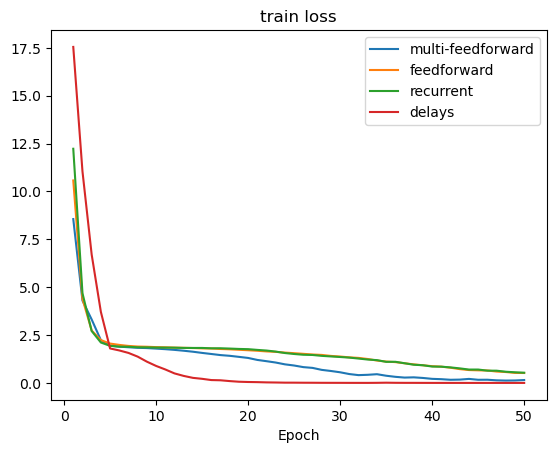

In [8]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
loss_error = np.mean(np.array(snn_f.train_loss)[:,1][-100:])
plot_per_epoch(snn_f.train_loss, label = 'multi-feedforward')
plot_per_epoch(snn_vf.train_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.train_loss, label = 'recurrent')
plot_per_epoch(snn_rd.train_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')
plt.title('train loss')

In [9]:
snn_vf

SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=25, out_features=64, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=6, bias=False)
    )
  )
)

In [11]:
snn_rnn.train_loss

[[1, 12.228657048543294],
 [2, 4.685059356689453],
 [3, 2.7101966094970704],
 [4, 2.110624910990397],
 [5, 1.9368317985534669],
 [6, 1.895227197011312],
 [7, 1.8880757013956706],
 [8, 1.8618081029256184],
 [9, 1.8569281323750815],
 [10, 1.8476689529418946],
 [11, 1.8441306749979656],
 [12, 1.8407122484842937],
 [13, 1.828866539001465],
 [14, 1.826380386352539],
 [15, 1.826951986948649],
 [16, 1.8082642110188802],
 [17, 1.8109068489074707],
 [18, 1.7948200416564941],
 [19, 1.775296802520752],
 [20, 1.7636742782592774],
 [21, 1.7254969533284505],
 [22, 1.69128391901652],
 [23, 1.6370574188232423],
 [24, 1.561400178273519],
 [25, 1.5112407239278158],
 [26, 1.4716514205932618],
 [27, 1.4603220558166503],
 [28, 1.4138142077128093],
 [29, 1.3837493260701497],
 [30, 1.3543495814005533],
 [31, 1.3227082379659016],
 [32, 1.272908509572347],
 [33, 1.2212911478678385],
 [34, 1.1911035029093424],
 [35, 1.1013114102681478],
 [36, 1.1044282372792562],
 [37, 1.0287375704447428],
 [38, 0.9503356011708

In [12]:
snn_vf.train_loss

[[1, 10.573075205485026],
 [2, 4.393300984700521],
 [3, 2.7361113739013674],
 [4, 2.2366601435343423],
 [5, 2.0561833953857422],
 [6, 1.985954818725586],
 [7, 1.9327837562561034],
 [8, 1.900972760518392],
 [9, 1.8899866612752279],
 [10, 1.8702287038167318],
 [11, 1.8606721115112306],
 [12, 1.8450701967875163],
 [13, 1.8341704432169597],
 [14, 1.822829475402832],
 [15, 1.805369815826416],
 [16, 1.7977081934611003],
 [17, 1.7728906695048015],
 [18, 1.755818697611491],
 [19, 1.7320839500427245],
 [20, 1.7072734832763672],
 [21, 1.680536003112793],
 [22, 1.6456000645955404],
 [23, 1.6221365165710449],
 [24, 1.5848969904581707],
 [25, 1.5536033884684244],
 [26, 1.519712568918864],
 [27, 1.4853664271036784],
 [28, 1.4629076321919758],
 [29, 1.4108799997965495],
 [30, 1.3786874516805012],
 [31, 1.335849437713623],
 [32, 1.3074515914916993],
 [33, 1.2499862734476725],
 [34, 1.168747075398763],
 [35, 1.115905548731486],
 [36, 1.087204532623291],
 [37, 1.0264690812428792],
 [38, 0.96925021489461

In [13]:
snn_f.debug = True
snn_rnn.debug = True
snn_rd.debug = True
snn_vf.debug = True
snn_f.init_state_logger()
snn_rnn.init_state_logger()
snn_rd.init_state_logger()
snn_vf.init_state_logger()


# from snn_delays.utils.train_utils_refact_minimal import propagate_batch_simple
# images, labels_mf = propagate_batch_simple(snn_f, test_loader)
# _, labels_rnn = propagate_batch_simple(snn_rnn, test_loader)
# _, labels_rd = propagate_batch_simple(snn_rd, test_loader)

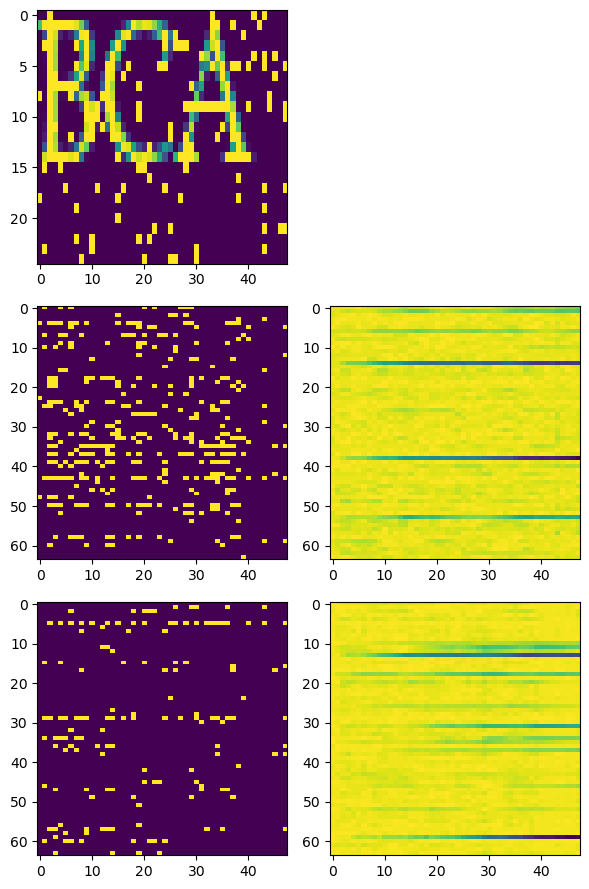

In [14]:
images, _ = propagate_batch_simple(snn_f, test_loader)
spk = snn_f.spike_state
mem = snn_f.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

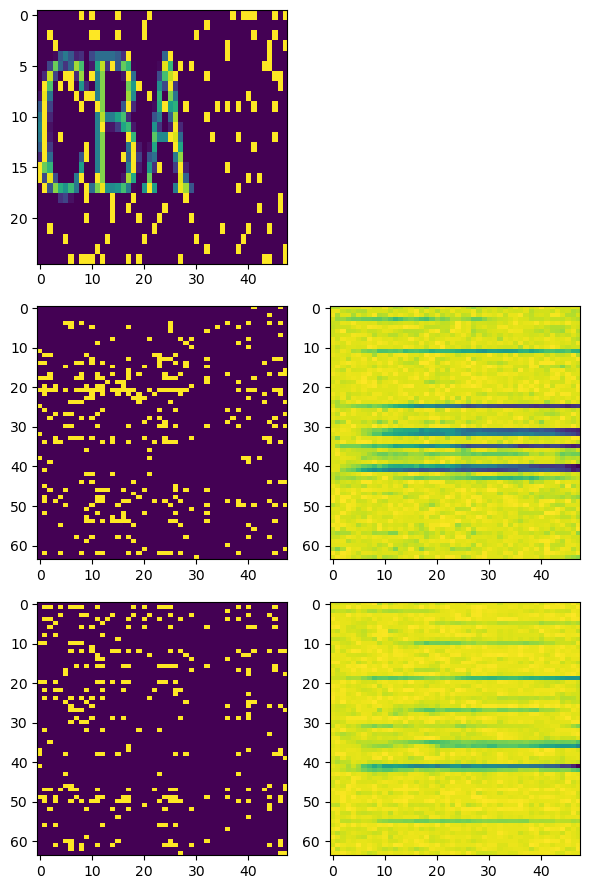

In [16]:
images, _ = propagate_batch_simple(snn_vf, test_loader)
spk = snn_vf.spike_state
mem = snn_vf.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

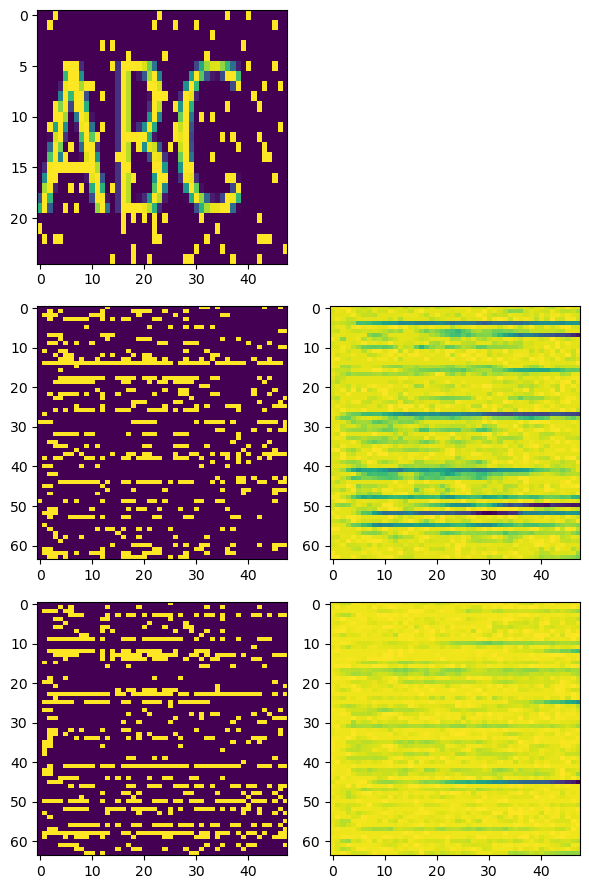

In [17]:
images, _ = propagate_batch_simple(snn_rnn, test_loader)
spk = snn_rnn.spike_state
mem = snn_rnn.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

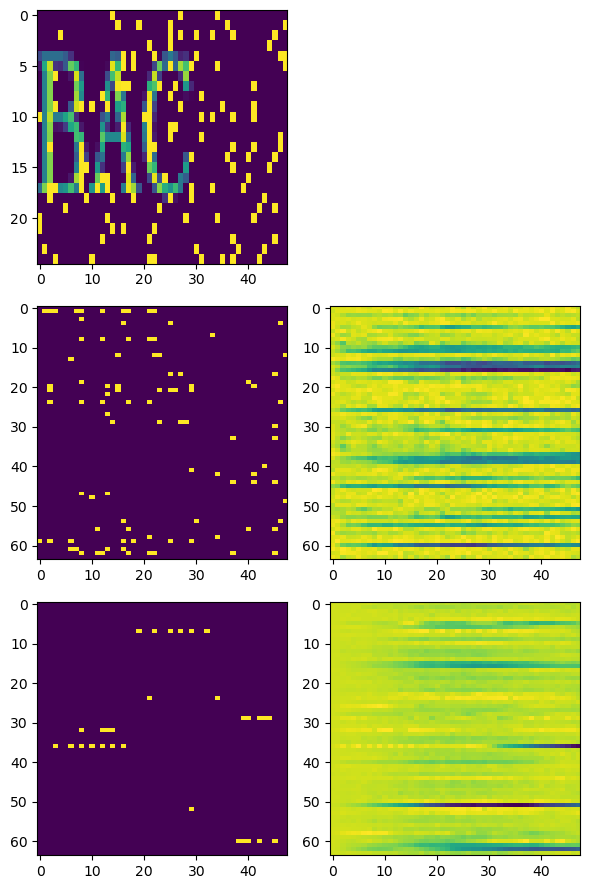

In [18]:
images, _ = propagate_batch_simple(snn_rd, test_loader)
spk = snn_rd.spike_state
mem = snn_rd.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

In [19]:
ckpt_dir = 'permuted_3letters_task'
snn_f.save_model('snn_mf', ckpt_dir)
snn_rnn.save_model('snn_rnn', ckpt_dir)
snn_rd.save_model('snn_rd', ckpt_dir)
snn_vf.save_model('snn_f', ckpt_dir)

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_3letters_task
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_3letters_task
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_3letters_task
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_3letters_task


In [26]:
from snn_delays.utils.model_loader_refac import ModelLoader
ckpt_dir = 'permuted_3letters_task'
snn_vf = ModelLoader('snn_f', ckpt_dir, 128, 'cuda')
snn_mf = ModelLoader('snn_mf', ckpt_dir, 128, 'cuda')
snn_rnn = ModelLoader('snn_rnn', ckpt_dir, 128, 'cuda')
snn_rd = ModelLoader('snn_rd', ckpt_dir, 128, 'cuda')

Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully


In [27]:
a, b = snn_vf.test(test_loader)
a, b = snn_mf.test(test_loader)
a, b = snn_rnn.test(test_loader)
a, b = snn_rd.test(test_loader)

600
Test Loss: 3.8834859848022463
Avg spk_count per neuron for all 48 time-steps 315.4225
Test Accuracy of the model on the test samples: 37.333

600
Test Loss: 4.638167381286621
Avg spk_count per neuron for all 48 time-steps 225.475
Test Accuracy of the model on the test samples: 50.667

600
Test Loss: 2.1304420471191405
Avg spk_count per neuron for all 48 time-steps 609.9308333333333
Test Accuracy of the model on the test samples: 44.500

600
Test Loss: 2.7111154079437254
Avg spk_count per neuron for all 48 time-steps 98.595
Test Accuracy of the model on the test samples: 56.667



Text(0.5, 1.0, 'train loss')

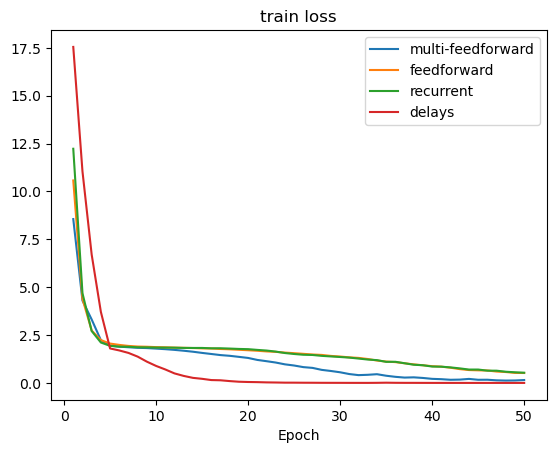

In [28]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
loss_error = np.mean(np.array(snn_f.train_loss)[:,1][-100:])
plot_per_epoch(snn_mf.train_loss, label = 'multi-feedforward')
plot_per_epoch(snn_vf.train_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.train_loss, label = 'recurrent')
plot_per_epoch(snn_rd.train_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')
plt.title('train loss')

Text(0.5, 1.0, 'train loss')

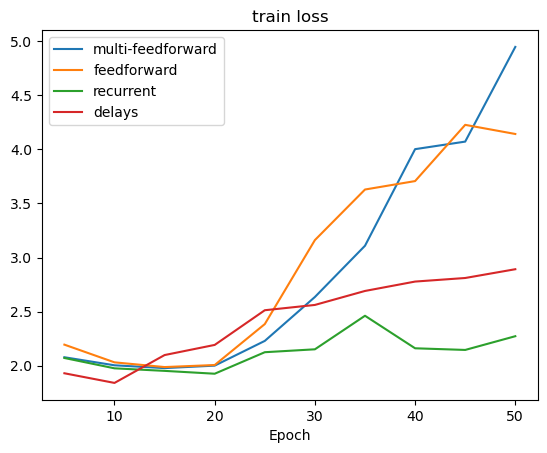

In [29]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
loss_error = np.mean(np.array(snn_f.train_loss)[:,1][-100:])
plot_per_epoch(snn_mf.test_loss, label = 'multi-feedforward')
plot_per_epoch(snn_vf.test_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.test_loss, label = 'recurrent')
plot_per_epoch(snn_rd.test_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')
plt.title('train loss')